In [113]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [114]:
# Load data
data_path = "data\\no-show-appintment-predictor-data.csv"
features = pd.read_csv(data_path)

In [115]:
# Grab a peek at the data
features.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [116]:
# Describe the shape of the data sample
print(features.shape)
print(features.describe)

(110527, 14)
<bound method NDFrame.describe of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0  

In [117]:
# Display the first 5 rows
features.iloc[:,5:].head(5)

,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,56,JARDIM DA PENHA,0,1,1,0,0,0,No


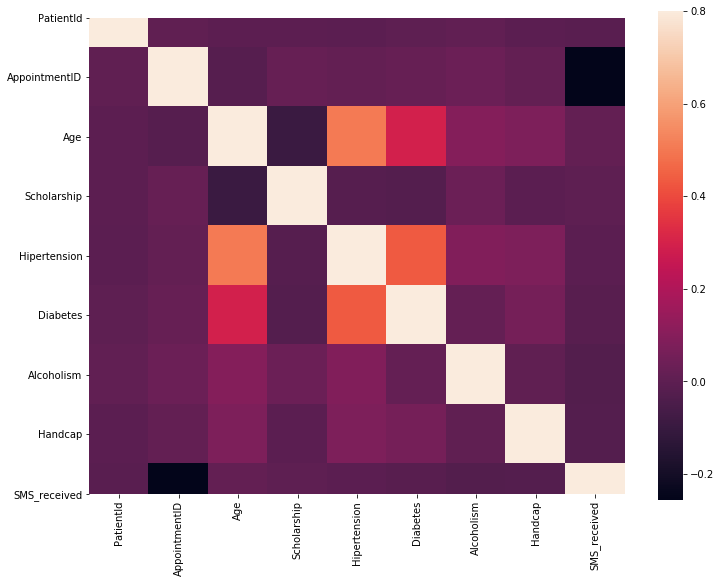

In [118]:
# Correlation matrix
corr_matrix = features.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

In [119]:
from sklearn import preprocessing
def convert(data):
    number = preprocessing.LabelEncoder()
    data['Neighbourhood'] = number.fit_transform(data.Neighbourhood)
    data['Gender'] = number.fit_transform(data.Gender)
    data['ScheduledDay'] = number.fit_transform(data.ScheduledDay)
    data['AppointmentDay'] = number.fit_transform(data.AppointmentDay)
    data['No-show'] = number.fit_transform(data['No-show'])
    data=data.fillna(-999)
    return data

features = convert(features)

# Labels are the values we want to predict
labels = np.array(features['No-show'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['PatientId','AppointmentID','No-show'], axis = 1)

#Convert string columns to float values by using preprocessing of the data

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [120]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#print('Executed')
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [121]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (82895, 11)
Training Labels Shape: (82895,)
Testing Features Shape: (27632, 11)
Testing Labels Shape: (27632,)


In [122]:
# Random forest is used as the model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

# Train the model on training data
rf.fit(train_features, train_labels);

C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [123]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.28 degrees.


In [124]:
# Add code here to view the important features using the feature_importances_ 
# property in the random forest regression model
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of the tuples with variables and the importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

#Print out the feature and importances
[print('Variable : {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable : ScheduledDay         Importance: 0.4
Variable : Age                  Importance: 0.2
Variable : Neighbourhood        Importance: 0.18
Variable : AppointmentDay       Importance: 0.12
Variable : Gender               Importance: 0.03
Variable : Scholarship          Importance: 0.02
Variable : Hipertension         Importance: 0.02
Variable : SMS_received         Importance: 0.02
Variable : Diabetes             Importance: 0.01
Variable : Alcoholism           Importance: 0.01
Variable : Handcap              Importance: 0.01


In [125]:
# Add code here to train again only based on the important features and
# measure the accuracy of the new random forest regression classsifier
# New random forest with only the two most important variables

rf_most_important = RandomForestRegressor()

#Extract the two most important features
important_indices = [feature_list.index('ScheduledDay'), feature_list.index('Age'), feature_list.index('Neighbourhood'),feature_list.index('AppointmentDay'),feature_list.index('Gender'),feature_list.index('SMS_received')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

#Train the random forest
rf_most_important.fit(train_important, train_labels)

C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [126]:
# Save the model using pickle
import pickle

file_name = "G:\\SLIIT\\OFFICIAL\\ML\\Assignment1\\no-show-appintment-predictor\\trainedModel\\no-show-appintment-predictor-model.sav"
pickle.dump(rf_most_important, open(file_name, 'wb'))

In [127]:
# Load the saved model to do the predictions
model_loaded = pickle.load(open(file_name, 'rb'))

In [128]:
#Make predictions and determine the error
predictions = model_loaded.predict(test_important)

errors = abs(predictions - test_labels)

#Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

np_array = (errors / test_labels)

# Convert nan values to number
np_array = errors / test_labels;
np_array[np.isnan(np_array)] = 0
np_array[np.isinf(np_array)] = 0

map = np.mean(100 * np_array)
accuracy = 100 - map

print('Accuracy: ', round(accuracy, 2), '%.')

Mean Absolute Error: 0.28 degrees.
Accuracy:  86.83 %.


C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\Suraj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
